In [1]:
import sys
sys.path.append('../support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from sampler import fitters
from astropy.coordinates import SkyCoord
from astropy.table import Table
import GCRCatalogs



Make sure we know which version we're using

In [2]:
clmm.__version__

'0.2.0'

#### Read in the extragalactic catalog

In [3]:
#extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [4]:
extragalactic_cat.halo_mass_def

'FoF, b=0.168'

In [5]:
sorted(q for q in extragalactic_cat.list_all_quantities() if 'halo' in q)

['halo_id', 'halo_mass']

In [6]:
#sorted(extragalactic_cat.list_all_quantities())

In [7]:
cosmo = extragalactic_cat.cosmology

#### Get the list of halos with `M > mmin` in the redshift range `[zmin, zmax]`

In [8]:
# get list of massive halos in a given redshift and mass range
mmin = 3.e14
zmin = 0.3
zmax = 0.4

massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec'],\
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'])


In [9]:
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters available')

# Selecting the most massive one
select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])

There are 9 clusters available


In [10]:
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
print (f'The most massive cluster is in z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is in z = 0.32, with mass = 6.36e+14 Msun


In [11]:
print(ra_cl,dec_cl)

64.25941267918058 -34.47274791810462


### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

In [12]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
mag_i_max = 25

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2','redshift', 'convergence'],\
                                           filters=(coord_filters + z_filters + mag_filters))



In [13]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(gal_cat['shear_1'],gal_cat['shear_2'],\
                                              shape_definition='shear',kappa=gal_cat['convergence'])

#store the results into an astropy table
dat = Table([gal_cat['ra'],gal_cat['dec'],e1,\
      e2,gal_cat['redshift'],gal_cat['galaxy_id']], \
      names=('ra','dec', 'e1', 'e2', 'z','id'))

cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

(array([1980., 2634., 2909., 4564., 3464., 3540., 3235., 3022., 2096.,
        2363., 1523., 1097.,  622.,  747.,  533.,  525.,  372.,  299.,
         145.,  207.,  162.,   68.,   86.,   51.,   46.,   41.,   30.,
          16.,   11.,   15.]),
 array([0.42088789, 0.50731391, 0.59373993, 0.68016595, 0.76659197,
        0.853018  , 0.93944402, 1.02587004, 1.11229606, 1.19872208,
        1.2851481 , 1.37157412, 1.45800015, 1.54442617, 1.63085219,
        1.71727821, 1.80370423, 1.89013025, 1.97655627, 2.0629823 ,
        2.14940832, 2.23583434, 2.32226036, 2.40868638, 2.4951124 ,
        2.58153842, 2.66796445, 2.75439047, 2.84081649, 2.92724251,
        3.01366853]),
 <a list of 30 Patch objects>)

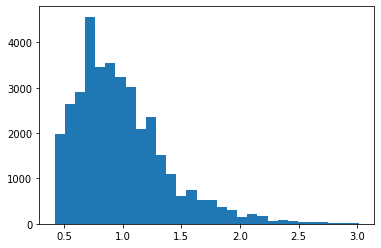

In [14]:
plt.hist(cl.galcat['z'], bins=30)

### Computes the tangential and cross shear profiles

#### Default binning

In [15]:
bin_edges = clmm.polaraveraging.make_bins(0.15, 10, 20, method='evenlog10width')
cl.compute_shear(geometry="flat")
profile = cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

/global/homes/c/ccombet/.conda/envs/clmmenv/lib/python3.8/site-packages/clmm-0.2.0-py3.8.egg/clmm/utils.py:43: RuntimeWarning: invalid value encountered in true_divide


In [16]:
profile

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
0.15,0.16924785308611714,0.18504898022151392,0.017855588154654,0.003864161668139595,0.013552416120058326,0.0037551438075395733,0.9814042121926486,0.06699524713146275,23
0.18504898022151392,0.21030006162978063,0.2282875005401484,0.02385065657822844,0.003491102909068496,-0.005053054737211326,0.0032863631463032603,1.043629411205765,0.07740776127411461,35
0.2282875005401484,0.2535203537421331,0.2816291278151518,0.032462744876425045,0.0029025656219321774,0.0014008296642004357,0.0021205929467541388,0.9860629390053413,0.05977536138198697,46
0.2816291278151518,0.315024383910832,0.3474345526857883,0.04218026075810955,0.0020691641963959304,0.0031671663934842937,0.001570415249677462,1.0284005628148185,0.050925508222643356,65
0.3474345526857883,0.3919984867602283,0.4286160644548199,0.04444789526603383,0.001409491090006505,0.0017790584455203689,0.0010340173510811582,0.9778036563572465,0.03145292785547417,92
0.4286160644548199,0.4816215189217207,0.5287664375594874,0.049734913847277164,0.0009738100188205113,-0.00028032960211139536,0.00048560979745372444,0.995792406151768,0.03535639992385144,146
0.5287664375594874,0.5959279674605111,0.6523179336383065,0.0463307571289655,0.0007420642472339589,-0.0002500203227770585,0.0003963940399269586,0.9687895347420731,0.024811197885398612,259
0.6523179336383065,0.7301942762580893,0.8047384559998254,0.03654147472908274,0.0005249825321886499,0.0006037974606862576,0.0004390383566344995,0.9220091378722484,0.018221047157527114,358
0.8047384559998254,0.9014631555828326,0.992773537518689,0.026295338828950097,0.0004358744910965249,-0.00045740044756464133,0.0003945140529868699,0.9875748130412275,0.017850719129770997,494


### Set up a model

In [17]:
reduced_shear_model = np.zeros(len(profile['radius']))

for i,r in enumerate(profile['radius']): 
    reduced_shear = clmm.predict_reduced_tangential_shear(r*cosmo.h, mass_cl*cosmo.h, 4.,z_cl, profile['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    reduced_shear_model[i] = np.mean(reduced_shear)    

Text(0, 0.5, '<shear>')

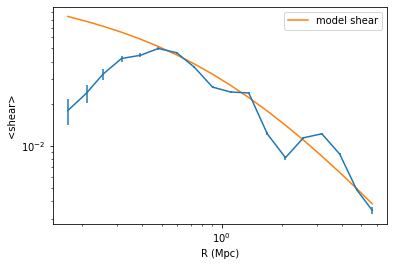

In [18]:
plt.errorbar(profile['radius'],profile['gt'],yerr=profile['gt_err'])
plt.plot(profile['radius'],reduced_shear_model, label='model shear')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')